Setting Up Environment

In [ ]:
!pip install praw

In [3]:
import praw
import time
import pandas as pd
from datetime import datetime
import re
import csv
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [ ]:
reddit = praw.Reddit(client_id='********',
                     client_secret='********',
                     user_agent='myRodneyReedApp:v1.0 (by u/Dodson22')

In [ ]:
subreddits = reddit.subreddit("all")

I decided to avoid specifying subreddits or date ranges to maximize the discourse collected on this topic.

In [ ]:
# list of keywords
keywords = '('Rodney Reed' OR '#RodneyReed' OR 'Justice for Rodney Reed' OR '#FreeRodneyReed' OR 'rodney reed' OR 'justice for rodney reed' OR 'free rodney reed')'

Collection of Posts

In [ ]:
# collect all post data
all_posts = []
limit = 1000

for submission in subreddits.search(keywords, sort='new', time_filter='all', limit=limit):
    all_posts.append({
        'id': submission.id,
        'title': submission.title,
        'selftext': submission.selftext,
        'created_utc': datetime.utcfromtimestamp(submission.created_utc),
        'subreddit': submission.subreddit.display_name,
        'author': str(submission.author),
        'score': submission.score,
        'num_comments': submission.num_comments,
        'permalink': f"https://www.reddit.com{submission.permalink}",
        'url': submission.url,
        'is_crosspost': hasattr(submission, 'crosspost_parent'),
        'is_link_post': submission.is_self is False,
        'domain': submission.domain if not submission.is_self else None
    })
    time.sleep(1)

In [ ]:
# save to CSV
df_posts = pd.DataFrame(all_posts)
df_posts.to_csv('rodney_reed_reddit_posts.csv', index=False)
print(f"Collected {len(df_posts)} posts total.")

Collected 222 posts total.

Collection of Comments

In [ ]:
# collect all comment data
all_comments = []

for post in all_posts:
    submission = reddit.submission(id=post['id'])
    submission.comments.replace_more(limit=None)  
    
    for comment in submission.comments.list():
        all_comments.append({
            'post_id': post['id'],
            'comment_id': comment.id,
            'author': str(comment.author),
            'body': comment.body,
            'score': comment.score,
            'created_utc': comment.created_utc,
            'is_submitter': comment.is_submitter,
            'permalink': f"https://reddit.com{comment.permalink}",
            'parent_id': comment.parent_id,
            'depth': comment.depth
        })
    time.sleep(1)

In [ ]:
# save comments to CSV 
df_comments = pd.DataFrame(all_comments)
df_comments.to_csv('rodney_reed_reddit_comments.csv', index=False)
print(f"Collected {len(df_comments)} comments total.")

Collected 2235 comments total.

Cleaning Posts and Comments

In [183]:
# load data for cleaning
df_posts = pd.read_csv('rodney_reed_reddit_posts.csv')
df_comments = pd.read_csv('rodney_reed_reddit_comments.csv')

In [186]:
# convert "created_utc" to date format as 'date'
# posts
df_posts['created_utc'] = pd.to_datetime(df_posts['created_utc'], errors='coerce')
df_posts['date'] = df_posts['created_utc'].dt.date

# comments
df_comments['created_utc'] = pd.to_datetime(df_comments['created_utc'], unit='s', errors='coerce')
df_comments['date'] = df_comments['created_utc'].dt.date

In [187]:
# create a 'month' column
df_posts['month'] = pd.to_datetime(df_posts['date']).dt.to_period('M').astype(str)
df_comments['month'] = pd.to_datetime(df_comments['date']).dt.to_period('M').astype(str)

In [188]:
# remove deleted/removed content
df_posts = df_posts[~df_posts['selftext'].isin(['[removed]', '[deleted]'])]
df_comments = df_comments[~df_comments['body'].isin(['[removed]', '[deleted]'])]

In [189]:
# remove duplicates
df_posts.drop_duplicates(subset='id', inplace=True)
df_comments.drop_duplicates(subset='comment_id', inplace=True)

In [190]:
# remove possible bots
df_posts = df_posts[~df_posts['author'].str.contains('bot', case=False, na=False)]
df_posts = df_posts[~df_posts['subreddit'].str.contains('bot', case=False, na=False)]
df_comments = df_comments[~df_comments['author'].str.contains('bot', case=False, na=False)]

In [191]:
# remove 'author' column to protect private information
df_posts = df_posts.drop(columns=['author'])
df_comments = df_comments.drop(columns=['author'])

In [192]:
# function for basic text cleaning
def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()  # lowercase
    text = re.sub(r'http\S+|www\S+', "", text)  # remove URLs
    text = re.sub(r'[^a-zA-Z\s]', "", text)  # remove special characters/numbers
    text = re.sub(r'\s+', " ", text)  # remove extra spaces
    return text.strip()

In [193]:
# combine and convert posts title and selftext
df_posts['text'] = df_posts['title'].fillna("") + " " + df_posts['selftext'].fillna("").astype(str)
# convert comments body to string
df_comments['text'] = df_comments['body'].fillna("").astype(str)

# clean texts
df_posts['cleaned_text'] = df_posts['text'].apply(clean_text)
df_comments['cleaned_text'] = df_comments['text'].apply(clean_text)

In [194]:
# save clean data to CSV for further analysis
df_posts.to_csv('cleaned_reddit_posts.csv', index=False)
df_comments.to_csv('cleaned_reddit_comments.csv', index=False)

Exploratory Data Analysis

In [4]:
# load data
df_posts = pd.read_csv('cleaned_reddit_posts.csv')
df_comments = pd.read_csv('cleaned_reddit_comments.csv')

In [5]:
# total number of posts and comments
total_posts = len(df_posts['id'])
total_comments = len(df_comments['comment_id'])

print(f'There are {total_posts} posts and {total_comments} comments after the cleaning process.')

There are 134 posts and 2114 comments after the cleaning process.


In [173]:
# view post dataframe
df_posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            134 non-null    object        
 1   title         134 non-null    object        
 2   selftext      32 non-null     object        
 3   created_utc   134 non-null    datetime64[ns]
 4   subreddit     134 non-null    object        
 5   score         134 non-null    int64         
 6   num_comments  134 non-null    int64         
 7   permalink     134 non-null    object        
 8   url           134 non-null    object        
 9   is_crosspost  134 non-null    bool          
 10  is_link_post  134 non-null    bool          
 11  domain        102 non-null    object        
 12  date          134 non-null    object        
 13  text          134 non-null    object        
 14  cleaned_text  134 non-null    object        
 15  month         134 non-null    object    

In [174]:
# view comment dataframe
df_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2114 entries, 0 to 2113
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   post_id       2114 non-null   object        
 1   comment_id    2114 non-null   object        
 2   body          2114 non-null   object        
 3   score         2114 non-null   int64         
 4   created_utc   2114 non-null   datetime64[ns]
 5   is_submitter  2114 non-null   bool          
 6   permalink     2114 non-null   object        
 7   parent_id     2114 non-null   object        
 8   depth         2114 non-null   int64         
 9   date          2114 non-null   object        
 10  text          2114 non-null   object        
 11  cleaned_text  2114 non-null   object        
 12  month         2114 non-null   object        
dtypes: bool(1), datetime64[ns](1), int64(2), object(9)
memory usage: 200.4+ KB


In [6]:
# posts by month
posts_by_month = df_posts['month'].value_counts().sort_index()
display(posts_by_month)

month
2019-11    11
2019-12     3
2020-02     7
2020-03     2
2020-04     1
2020-05     3
2020-07     4
2020-12     1
2021-01     2
2021-03     4
2021-06     1
2021-07    12
2021-08     1
2021-09     2
2021-10     2
2021-11    18
2022-02     1
2022-04     7
2022-05     1
2022-06     1
2022-09     1
2022-10    13
2023-01     1
2023-04    15
2023-05     1
2023-06     6
2023-07     6
2023-11     1
2024-05     1
2024-07     3
2024-08     1
2024-09     1
Name: count, dtype: int64

In [7]:
# comments by month
comments_by_month = df_comments['month'].value_counts().sort_index()
display(comments_by_month)

month
2019-11    188
2019-12     42
2020-01      6
2020-02      7
2020-03     19
2020-05     57
2020-07     34
2020-08      4
2020-11      3
2020-12    181
2021-01     16
2021-02      5
2021-03     34
2021-04      3
2021-05     26
2021-06     56
2021-07     83
2021-08     22
2021-09     49
2021-10     14
2021-11     68
2021-12      3
2022-01     18
2022-02      3
2022-04     60
2022-05     72
2022-06     38
2022-07     78
2022-08     17
2022-09    129
2022-10     75
2022-11      2
2022-12      4
2023-01    102
2023-02     22
2023-03      5
2023-04    296
2023-05     42
2023-06     43
2023-07     44
2023-08     12
2023-09      4
2023-10      8
2023-11     26
2023-12      1
2024-01      3
2024-02      6
2024-05      1
2024-06      1
2024-07     37
2024-08     23
2024-09      7
2024-10      5
2024-11      1
2024-12      6
2025-01      2
2025-02      1
Name: count, dtype: int64

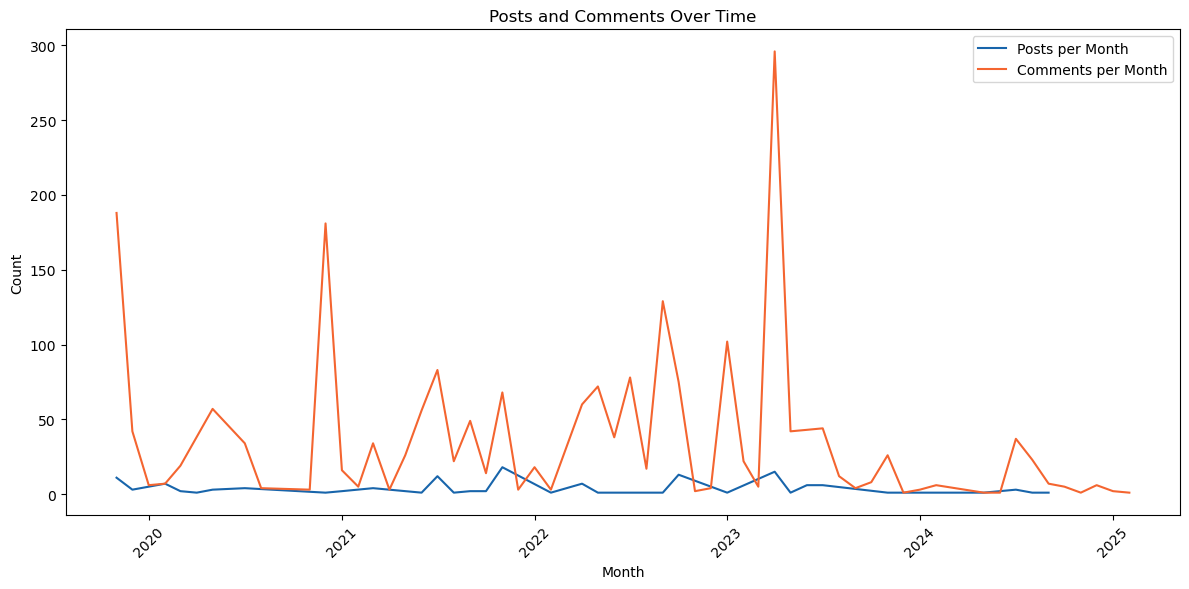

In [10]:
# Post and Comments Over Time
# set index for posts
posts_by_month.index = pd.PeriodIndex(posts_by_month.index, freq='M')
posts_by_month.index = posts_by_month.index.to_timestamp()
# set index for comments
comments_by_month.index = pd.PeriodIndex(comments_by_month.index, freq='M')
comments_by_month.index = comments_by_month.index.to_timestamp()

plt.figure(figsize=(12, 6))
plt.plot(posts_by_month.index,
         posts_by_month,
         label='Posts per Month', 
         color='#1865ab'
         )
plt.plot(comments_by_month.index,
         comments_by_month,
         label='Comments per Month', 
         color='#f46530'
        )

plt.title('Posts and Comments Over Time')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Exploratory Analysis of Posts

In [209]:
# date range
posts_start = df_posts['date'].min()
posts_end = df_posts['date'].max()

print(f'Posts were collected from {posts_start} to {posts_end}.')

Posts were collected from 2019-11-22 to 2024-09-19.


In [140]:
# average length of posts
post_text_length = df_posts['selftext'].fillna('').apply(lambda x: len(x.split()))
avg_length_post = round(post_text_length.mean())
print(f'Average post length: {avg_length_post} words')

Average post length: 158 words


In [119]:
# number of crossposts
crossposts = df_posts[df_posts['is_crosspost'] == True]
print(f'There are {crossposts.shape[0]} posts shared from another subreddit.')

There are 3 posts shared from another subreddit.


In [118]:
# number of linked post
link_post = df_posts[df_posts['is_link_post'] == True]
print(f'There are {link_post.shape[0]} posts with links attached.')

There are 102 posts with links attached.


In [125]:
# top 10 domains linked
top_domains = df_posts['domain'].value_counts().head(10)
display(top_domains)

domain
theintercept.com      19
nytimes.com           15
cnn.com                7
liberationnews.org     7
kvue.com               6
kxan.com               6
chron.com              4
statesman.com          4
youtube.com            3
cbsaustin.com          3
Name: count, dtype: int64

In [227]:
# number of comments per post statistics
post_num_comments = df_posts['num_comments']
print(f'Average Number of Comments: {post_num_comments.mean()} \nLowest Number of Comments: {post_num_comments.min()} \nHighest Number of Comments: {post_num_comments.max()} \n')
print(post_num_comments.describe())

Average Number of Comments: 16.761194029850746 
Lowest Number of Comments: 0 
Highest Number of Comments: 228 

count    134.000000
mean      16.761194
std       38.991840
min        0.000000
25%        0.000000
50%        1.000000
75%       10.750000
max      228.000000
Name: num_comments, dtype: float64


In [50]:
# post with the most comments
most_commented = df_posts.sort_values(by='num_comments', ascending=False)[['title', 'subreddit', 'num_comments', 'score']].head(10)
display(most_commented)

,title,subreddit,num_comments,score
102,Kim Kardashian and other celebs believe Rodney...,UnresolvedMysteries,228,211
22,"Supreme Court Lets Rodney Reed, a Texas Death ...",politics,172,3665
50,Question regarding Rodney Reed (convicted of m...,UnresolvedMysteries,167,87
123,List of True Crime Podcasts - one case per pod...,TrueCrimePodcasts,161,853
49,Upcoming Supreme Court cases that could change...,Keep_Track,133,1448
58,SCOTUS Agrees to Take Up Death Row Inmate Rodn...,scotus,128,149
45,Texas Claims It’s “Too Late” for DNA Testing T...,Austin,110,423
35,New(ish) listener here….I just got to episode ...,MorbidPodcast,104,31
33,U.S. Supreme Court lets Texas death row inmate...,Austin,95,287
88,Can Rodney Reed Be Freed? - New testimony rive...,Austin,83,54


In [49]:
# post with the least comments
least_commented = df_posts.sort_values(by='num_comments', ascending=True)[['title', 'subreddit', 'num_comments', 'score']].head(10)
display(least_commented)

,title,subreddit,num_comments,score
128,Guess Who Is Supporting Rodney Reed Now,atheismisunstoppable,0,13
12,Dozens of Witnesses Say Rodney Reed Is Innocen...,Intercept,0,2
78,Recommendation about a new trial for Rodney Re...,BastropTX,0,8
81,Rodney Reed,TrueCrimeDiscussion,0,3
84,LIVE UPDATES: Forensic pathologist disagrees w...,BastropTX,0,4
85,"False memories, time of death analyzed during ...",BastropTX,0,5
86,Day 5: Attorneys for the state begin their cas...,BastropTX,0,3
69,Rodney Reed Should Not Be Retried in Texas Mur...,nytimes,0,3
70,[National] - Rodney Reed Should Not Be Retried...,AutoNewspaper,0,2
71,[National] - Rodney Reed Should Not Be Retried...,NYTauto,0,2


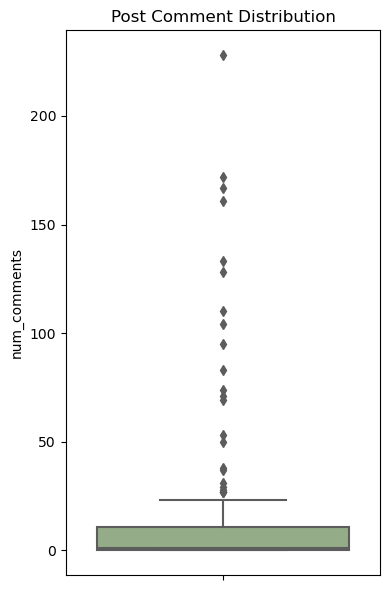

In [121]:
plt.figure(figsize=(4, 6))
sns.boxplot(y=df_posts['num_comments'], color='#92b281')

plt.title('Post Comment Distribution')

plt.tight_layout()
plt.show()

In [226]:
# post score statistics
post_score = df_posts['score']
print(f'Average Post Score: {post_score.mean()} \nLowest Score: {post_score.min()} \nHighest Score: {post_score.max()} \n')
display(post_score.describe())

Average Post Score: 65.13432835820896 
Lowest Score: 0 
Highest Score: 3665 



count     134.000000
mean       65.134328
std       348.217648
min         0.000000
25%         1.000000
50%         3.000000
75%        16.750000
max      3665.000000
Name: score, dtype: float64

In [48]:
# posts with the highest scores
top_posts = df_posts.sort_values(by='score', ascending=False)[['title', 'subreddit', 'score', 'num_comments', 'date']].head(10)
display(top_posts)

,title,subreddit,score,num_comments,date
22,"Supreme Court Lets Rodney Reed, a Texas Death ...",politics,3665,172,2023-04-29 22:45:18
49,Upcoming Supreme Court cases that could change...,Keep_Track,1448,133,2022-09-07 13:58:54
123,List of True Crime Podcasts - one case per pod...,TrueCrimePodcasts,853,161,2019-11-27 10:37:14
45,Texas Claims It’s “Too Late” for DNA Testing T...,Austin,423,110,2022-10-10 21:31:21
33,U.S. Supreme Court lets Texas death row inmate...,Austin,287,95,2023-04-19 17:10:54
102,Kim Kardashian and other celebs believe Rodney...,UnresolvedMysteries,211,228,2020-12-09 19:58:37
21,"Supreme Court Lets Rodney Reed, a Texas Death ...",law,204,14,2023-04-29 23:51:39
58,SCOTUS Agrees to Take Up Death Row Inmate Rodn...,scotus,149,128,2022-04-25 15:28:33
7,Jordan Smith - Dozens of Witnesses Say Rodney ...,law,93,38,2023-07-10 03:31:51
34,"In Reed v Goertz, the Supreme Court revives ca...",scotus,88,28,2023-04-19 14:14:17


In [44]:
# posts with the lowest scores
low_posts = df_posts.sort_values(by='score', ascending=True)[['title', 'subreddit', 'score', 'date']].head(10)
display(low_posts)

,title,subreddit,score,date
122,What can we do about the Travis Runnels execut...,texas,0,2019-12-08 17:23:34
120,"With help from the Innocence Project, nearly t...",Positive_News,0,2019-12-12 16:44:00
126,Michael Baden: Death row inmate Rodney Reed is...,MelanoidNation,0,2019-11-25 10:39:02
51,(Give Rodney a chance!!)Rodney Reed − overturn...,howardstern,0,2022-05-06 22:00:06
129,Rodney Reed case assigned new judge,texas,0,2019-11-22 23:44:28
118,[Politics] - Supreme Court won't take up Rodne...,AutoNewspaper,1,2020-02-24 15:51:33
17,Texas Court of Criminal Appeals rejects Rodney...,TrueCrimeUpdates,1,2023-06-28 17:42:31
116,Supreme Court won't take up Rodney Reed appeal,StateoftheUnionNONF,1,2020-02-24 19:09:10
20,"Supreme Court Lets Rodney Reed, a Texas Death ...",u_NumerousRow,1,2023-04-30 00:44:40
24,SCOTUS allows Rodney Reed to pursue DNA testin...,The_FoxNewsNetwork,1,2023-04-20 03:54:01


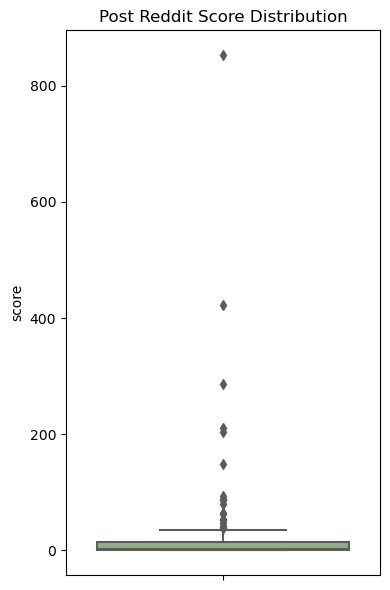

In [101]:
# post score distribution (excluding 2 outliers)
outliers = df_posts['score'].nlargest(2).index
filtered_scores = df_posts.drop(index=outliers)['score']

plt.figure(figsize=(4, 6))
sns.boxplot(y=filtered_scores, color='#92b281')

plt.title('Post Reddit Score Distribution')

plt.tight_layout()
plt.show()

Exploratory Analysis by Subreddit

In [217]:
# number of posts per subreddit
subreddits = df_posts.groupby('subreddit').size()
subreddits = subreddits.sort_values(ascending=False)

print(subreddits.head(15))

subreddit
AutoNewspaper          16
BastropTX              14
Austin                  8
TrueCrimeDiscussion     6
TheIntercept            5
texas                   4
NYTauto                 4
Intercept               4
prisons                 3
creeptimethepodcast     2
LiberationNews          2
UnresolvedMysteries     2
KUWTK                   2
HOUSTONCHRONauto        2
law                     2
dtype: int64


In [218]:
# average score by subreddit
subreddit_score = df_posts.groupby('subreddit')['score'].mean()
subreddit_score = subreddit_score.sort_values(ascending=False)

print(subreddit_score.head(15))

subreddit
politics               1864.5
Keep_Track             1448.0
TrueCrimePodcasts       428.0
UnresolvedMysteries     149.0
law                     148.5
scotus                  118.5
Austin                  114.0
hercreation              87.0
KUWTK                    60.5
TexasPolitics            47.0
2020Reclamation          42.0
COMPLETEANARCHY          35.0
AmericasSocialists       32.0
TrueCrime                30.0
socialism                23.0
Name: score, dtype: float64


Exploratory Analysis of Comments

In [219]:
# date range for comments
comments_start = df_comments['date'].min()
comments_end = df_comments['date'].max()

print(f'Comments were collected from {comments_start} to {comments_end}.')

Comments were collected from 2019-11-22 to 2025-02-21.


In [29]:
# average length of comments
comment_text_length = df_comments['cleaned_text'].apply(lambda x: len(x.split()))
avg_length_comment = round(comment_text_length.mean())
print(f'Average comment length: {avg_length_comment} words')

Average comment length: 69 words


In [117]:
# number of times post author commented
submitter = df_comments[df_comments['is_submitter'] == True]
print(f'There are {submitter.shape[0]} comments that were made by the original author.')

There are 176 comments that were made by the original author.


In [229]:
# comment score statistics
comment_score = df_comments['score']
print(f'Average Comment Score: {comment_score.mean()} \nLowest Score: {comment_score.min()} \nHighest Score: {comment_score.max()} \n')
print(comment_score.describe())

Average Comment Score: 8.439451277199622 
Lowest Score: -46 
Highest Score: 1428 

count    2114.000000
mean        8.439451
std        38.957102
min       -46.000000
25%         1.000000
50%         2.000000
75%         6.000000
max      1428.000000
Name: score, dtype: float64


In [24]:
# comments with the highest scores
top_comments = df_comments.sort_values(by='score', ascending=False)[['comment_id', 'body', 'score', 'date']].head(10)
display(top_comments)

,comment_id,body,score,date
229,ji8mflf,"> In a separate dissent, Justice Clarence Thom...",1428,2023-04-29 22:54:32
253,ji8mp31,If the devil wrote a satirical parody about hi...,513,2023-04-29 22:56:38
766,ingefq0,*Moore v. Harper* is terrifying.,383,2022-09-07 14:34:30
797,ingidah,"Yup, that's the one that would legit just end ...",296,2022-09-07 15:00:33
1634,gf7cjxy,"I'm not convinced he's innocent, but there's m...",242,2020-12-09 20:18:20
233,ji8oq4y,">In a separate dissent, Justice Clarence Thoma...",225,2023-04-29 23:12:53
767,inghx8t,Why do I feel like I can count on this Supreme...,224,2022-09-07 14:57:37
231,ji8t39l,"Imagine having to ""let"" someone prove they sho...",211,2023-04-29 23:48:06
1637,gf7hkc7,I really can't take Kim Kardashian serious aft...,210,2020-12-09 20:57:02
1633,gfaogsl,Kim Kardashian and others are severely misinfo...,196,2020-12-10 16:34:36


In [46]:
# comments with the lowest scores
low_comments = df_comments.sort_values(by='score', ascending=True)[['comment_id', 'body', 'score', 'date']].head(10)
display(low_comments)

,comment_id,body,score,date
1414,h0fyd1w,OJ and Derek Chauvin.\nOJ is self explanatory....,-46,2021-06-03 14:24:16
642,irtovhw,He's a child rapist. Let him burn,-31,2022-10-10 23:28:45
1565,gf7xqkl,Too long. Didn't have to read.\n\nWhy do peopl...,-18,2020-12-09 23:10:20
28,lbe0wte,I don't believe in the death penalty but that ...,-17,2024-07-03 03:13:13
405,jgxbr1m,Get your facts straight about the 12 year old....,-15,2023-04-19 20:17:56
1178,hixh13n,Haven’t heard of him before and don’t know muc...,-13,2021-11-01 20:51:46
99,jrd6rh0,Poor Rodney Reed. Talk about bad luck. He ha...,-13,2023-07-10 04:42:47
798,inhcebw,MLK and Gandhi showed the way: non-violent *re...,-12,2022-09-07 18:11:14
400,jgx0trn,Allegedly,-11,2023-04-19 19:08:58
419,jgxq841,DNA appeared in those rape kits along with sev...,-10,2023-04-19 21:51:06


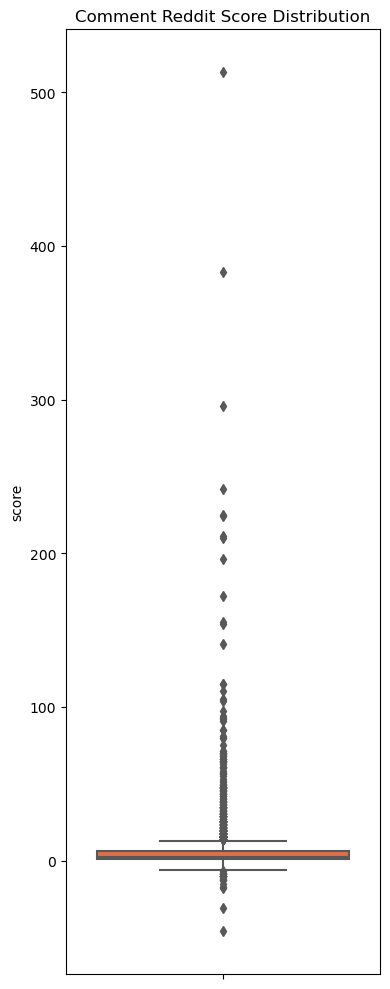

In [83]:
# comment sentiment distribution (exluding 1 outlier)
outlier = df_comments['score'].max()
filtered_scores = df_comments[df_comments['score'] != outlier]['score']

plt.figure(figsize=(4, 10))
sns.boxplot(y=filtered_scores, color='#f46530')
plt.title('Comment Reddit Score Distribution')

plt.tight_layout()
plt.show()